Trabajo realizado por Luis De Marcos Mazarío para la UCM en 2022

# Introduction

Your goal is to predict the operating condition of a waterpoint for each record in the dataset. You are provided the following set of information about the waterpoints:

In [1]:
info = """id - Pump identifier
amount_tsh - Total static head (amount water available to waterpoint)
date_recorded - The date the row was entered
funder - Who funded the well
gps_height - Altitude of the well
installer - Organization that installed the well
longitude - GPS coordinate
latitude - GPS coordinate
wpt_name - Name of the waterpoint if there is one
num_private - Unknown
basin - Geographic water basin
subvillage - Geographic location
region - Geographic location
region_code - Geographic location (coded)
district_code - Geographic location (coded)
lga - Geographic location
ward - Geographic location
population - Population around the well
public_meeting - True/False
recorded_by - Group entering this row of data
scheme_management - Who operates the waterpoint
scheme_name - Who operates the waterpoint
permit - If the waterpoint is permitted
construction_year - Year the waterpoint was constructed
extraction_type - The kind of extraction the waterpoint uses
extraction_type_group - The kind of extraction the waterpoint uses
extraction_type_class - The kind of extraction the waterpoint uses
management - How the waterpoint is managed
management_group - How the waterpoint is managed
payment - What the water costs
payment_type - What the water costs
water_quality - The quality of the water
quality_group - The quality of the water
quantity - The quantity of water
quantity_group - The quantity of water
source - The source of the water
source_type - The source of the water
source_class - The source of the water
waterpoint_type - The kind of waterpoint
waterpoint_type_group - The kind of waterpoint"""

The labels in this dataset are simple. There are three possible values:

- functional (0): the waterpoint is operational and there are no repairs needed
- functional needs repair (1): the waterpoint is operational, but needs repairs
- non functional (2): the waterpoint is not operational

# Imports and Functions

In [ ]:
import random
import os
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier, VotingClassifier, 
                              GradientBoostingClassifier, RandomForestRegressor, StackingClassifier)
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import (GridSearchCV, cross_val_score, RepeatedStratifiedKFold, 
StratifiedKFold, RandomizedSearchCV)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import category_encoders as ce

import warnings
warnings.filterwarnings(action='ignore')
import time

In [5]:
def get_metrics(tags, predictions):
    print('F1 Score:',f1_score(tags, predictions, average='macro'))
    print('Accuracy Score:',accuracy_score(tags, predictions))
    print(confusion_matrix(tags, predictions))

def show_features_importance(model, features, n_best=None):
    if not n_best or n_best > len(features):
        n_best = len(features)
    size = n_best if n_best < len(features) else len(features)
    importance = model.feature_importances_
    importance_dict = {}
    total = 0
    for v,i in sorted(zip(importance, features), reverse=False):
        total += v
        importance_dict[i] = v

    plt.figure(figsize=(10,size/2))
    plt.barh(list(importance_dict.keys())[len(features)-n_best:], 
             list(importance_dict.values())[len(features)-n_best:], color='g')
    plt.show()

def show_missing_unique(df, data=None):
    dfx = pd.DataFrame({'type':df.dtypes,
                  'missing':df.isnull().sum(),
                  '% missing':round(df.isnull().sum()*100/len(df),2),
                  'unique':[len(df[col].unique()) for col in df.columns],
                  '% unique':[round(len(df[col].unique())*100/len(df),2) for col in df.columns]})
    if data:
        dfx['description'] = [x.split(' - ')[1] for x in data.split('\n')]
    return dfx.style.background_gradient(cmap='viridis')

def find_best_cut(y_test, preds_proba, granularity=0.1, low=0, high=1):
    results = [(accuracy_score(y_test, [2 if x[2] >= i else np.argmax(x[:-1]) for x in preds_proba]), i)
               for i in np.arange(low,high,granularity)]
    return sorted(results)[-1]

def plot_corr(df):
    df = df.copy()
    for col in df.select_dtypes(include='O'):
        df[col] = LabelEncoder().fit_transform(df[col])
    plt.figure(figsize=(10,8))
    sns.heatmap(df.corr())
    #display(abs(df.corr()).style.background_gradient(cmap='viridis'))
    
def check_unique_values(df, columns):
    for col in columns:
        print(sorted([x for x in df[col].unique() if x is not np.nan]))
    
def find_features_importance(X_train, y_train):
    xgb = XGBClassifier(random_state=42, n_jobs=-1, verbosity=0).fit(X_train, y_train).feature_importances_
    rf = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_train, y_train).feature_importances_
    cat = CatBoostClassifier(random_state=42, silent=True).fit(X_train, y_train).feature_importances_
    importances = sorted([(np.mean([x,y,z]),c) for x,y,z,c in zip(xgb, rf, cat, X_train.columns)])
    plt.figure(figsize=(10,len(X_train.columns)/2))
    plt.barh(list(zip(*importances))[1], list(zip(*importances))[0])
    return sorted(importances, reverse=True)

def plot_map(df, color=None):
    plt.figure(figsize=(7,5))
    plt.scatter(df.latitude, df.longitude, s=5, c=color)
    plt.colorbar()

def plot_categoricals(df, tag, col):
    labels = df[col].unique()
    plt.figure(figsize=(10,5))
    qs = [df[tag == i][col].value_counts() for i in np.unique(tag)]
    qs = [[q[l] if l in q else 0 for l in labels] for q in qs]
    acc = np.zeros(len(labels))
    for val, c in zip(qs, ['green','orange','red','blue','yellow','black']):
        plt.bar(labels, val, bottom=acc, color=c)
        acc = acc + val
    plt.xticks(rotation=90)
    plt.title(col)
    plt.show()

In [ ]:
NUMERICS = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# Exploratory Data Analysis

El primer paso es cargar los datos. Para ello, generaremos un dataframe con los datos de entrenamiento y testing, para poder analizarlos en conjunto y poder aplicar las transformaciones a todos los datos simultáneamente. Además, cargaremos en una variable `tag` la variable objetivo a predecir

In [3]:
# Cargamos los datos
df = pd.concat([pd.read_csv('data/training.csv'), pd.read_csv('data/test.csv')])
tag = LabelEncoder().fit_transform(pd.read_csv('data/labels.csv')['status_group'])
test_ids = df[len(tag):]['id']

Mostramos los valores perdidos, únicos, el tipo y la descripción de cada variable para hacernos una idea inicial de los datos con los que estamos trabjando

In [6]:
show_missing_unique(df.replace(0, np.nan), info)

,type,missing,% missing,unique,% unique,description
id,float64,1,0.000000,74250,100.000000,Pump identifier
amount_tsh,float64,52049,70.100000,102,0.140000,Total static head (amount water available to waterpoint)
date_recorded,object,0,0.000000,369,0.500000,The date the row was entered
funder,object,4504,6.070000,2141,2.880000,Who funded the well
gps_height,float64,25649,34.540000,2456,3.310000,Altitude of the well
installer,object,4532,6.100000,2411,3.250000,Organization that installed the well
longitude,float64,2269,3.060000,71870,96.790000,GPS coordinate
latitude,float64,0,0.000000,71869,96.790000,GPS coordinate
wpt_name,object,0,0.000000,45684,61.530000,Name of the waterpoint if there is one
num_private,float64,73299,98.720000,68,0.090000,Unknown


Nos encontramos con una gran cantidad de variables categóricas. Además se observa que parece que hay variables repetidas o en pares, las cuales analizaremos posteriormente.

Observamos aquellas variables que son extrañas por su descripción, número de missings o número de uniques. Hay que tener en cuenta que el número de missings de las variables booleanas no corresponde con la realidad, puesto que estamos reemplazando valores False con missing.

In [7]:
initial_drop = [
    'id', # Identifier
    'wpt_name', # Not interesting
    'num_private', # Unknown + almost all values are 0
    'recorded_by', # Not interesting
    'scheme_name' # Too many missing values
]

df.drop(columns=initial_drop, inplace=True)

Realizamos un análisis de correlación para comprobar si las variables están repetidas.

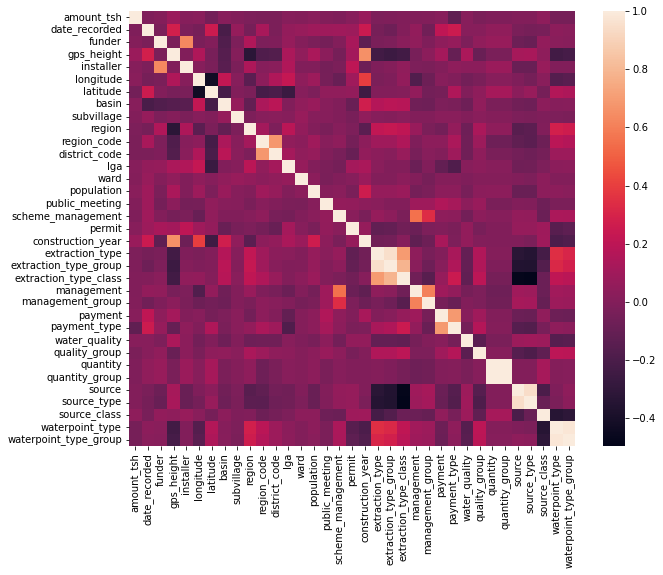

In [28]:
plot_corr(df)

In [8]:
# Eliminamos las columnas por ser repetidas. 
# Hemos seleccionado aquellas variables categóricas que son muy similares a otras de la misma clase

repeated_columns = [
    'extraction_type_group',
    'quantity_group',
    'source_type',
    'waterpoint_type_group',
    'payment_type',
    'management_group',
    'extraction_type',
    'water_quality',
    'management',
    'installer'
]

df.drop(columns=repeated_columns, inplace=True)

Procedemos a realizar feature engineering. La variable `date_recorded` la pasaremos a formato año y la asignaremos a una nueva variable denominada `year_recorded`. Además imputaremos aquellos años de la variable `construction_year` que sean igual a 0 con el valor medio. Hecho esto, imputaremos con el valor medio los datos de `year_recorded` que sean inferiores a su respectivo valor de `construction_year`, puesto que no es posible que la fecha de construcción sea superior a la de inspección del pozo. 

Una vez hecho esto, generamo una nueva variable denominada `age` que contendrá la edad del pozo desde que se construyó hasta que se realizó la inspección. Por último, eliminaremos las columnas necesarias para la generación de esta nueva variable.

In [11]:
# Generamos 2 nuevas columnas: Año y mes en el que se recogió el dato
df['year_recorded'] = pd.DatetimeIndex(df ['date_recorded']).year

df.drop(columns=['date_recorded'], inplace=True)

# Asignamos el valor medio a aquellos valores de year recorded que sean inferiores a construction_year,
# de esta forma evitaremos aquellos pozos cuya edad sea inferior a 0 (no posible)
mean_year_recorded = round(df.loc[df.year_recorded > df.construction_year, 'year_recorded'].mean())
df.loc[df.year_recorded < df.construction_year, 'year_recorded'] = mean_year_recorded

# Rellenamos el año de construcción con la media de los valores
df['construction_year'].replace(0, round(df.loc[df['construction_year'] > 0, 'construction_year'].mean()), inplace=True)

# Calculamos la edad de los pozos
df['age'] = df['year_recorded'] - df['construction_year']
df.drop(columns=['year_recorded','construction_year'], inplace=True)

A continuación procedemos a tratar las variables relacionadas con GPS. Observamos en el siguiente mapa de latitud-longitud-altura gsps, que hay muchos valores 0 de altura y valores 0 de latitud y longitud. Vamos a tratarlos haciendo uso del algoritmo de regresión lineal en base a los valores de otras columnas como region, lga, ward, que corresponden a zonas geográficas.

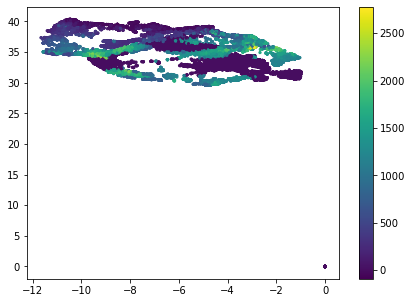

In [10]:
plot_map(df, df['gps_height'])

El primer paso consiste en pasar los valores perdidos a np.nan. Una vez hecho esto, entrenaremos con variables como `lga`, `region`, entre otras (se pasarán a numéricas mediante un LabelEncoder), un modelo de regresión lineal para latitud y longitud. 

Una vez se hayan imputado los valores perdidos de `latitude` y `longitude`, se entrena un modelo de regresión lineal basado en estas 2 variables, y con ello imputamos los valores perdidos de `gps_height`.

In [12]:
# Asignamos a longitude = 0 y latitude > -0.3 el valor np.nan | Asignamos np.nan a gps_height = 0
df.loc[df.latitude > -0.3, 'latitude'] = np.nan
df.loc[df.longitude == 0, 'longitude'] = np.nan
df.loc[df.gps_height == 0, 'gps_height'] = np.nan

# Imputamos los valores geográficos en base a los valores geográficos
df_encoded = df[['region','region_code','district_code','lga','ward']].copy()
for col in df_encoded:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])
df_encoded[['latitude','longitude']] = df[['latitude','longitude']]

# Latitude
reg = LinearRegression(n_jobs=-1).fit(df_encoded.loc[df_encoded.latitude.notna()].drop(columns=['latitude','longitude']),
                                          df_encoded.loc[df_encoded.latitude.notna(), 'latitude'])
x = reg.predict(df_encoded.loc[df_encoded.latitude.isna()].drop(columns=['latitude','longitude']))
df.loc[df.latitude.isna(), 'latitude'] = x

# Longitude
reg = LinearRegression(n_jobs=-1).fit(df_encoded.loc[df_encoded.longitude.notna()].drop(columns=['latitude','longitude']),
                                          df_encoded.loc[df_encoded.longitude.notna(), 'longitude'])
x = reg.predict(df_encoded.loc[df_encoded.longitude.isna()].drop(columns=['latitude','longitude']))
df.loc[df.longitude.isna(), 'longitude'] = x

# Mismo proceso para gps_height
df_encoded[['latitude','longitude','gps_height']] = df[['latitude','longitude','gps_height']]

reg = LinearRegression(n_jobs=-1).fit(df_encoded.loc[df_encoded.gps_height.notna()].drop(columns=['gps_height']),
                                          df_encoded.loc[df_encoded.gps_height.notna(), 'gps_height'])
x = reg.predict(df_encoded.loc[df_encoded.gps_height.isna()].drop(columns=['gps_height']))

df.loc[df.gps_height.isna(), 'gps_height'] = x

# Eliminamos las columnas relacionadas con localización 
location_columns = [
    'region_code', # Alta relación con district_code
    'subvillage' # Gran cantidad de valores únicos. Preferimos usar los valores de latitud y longitud
]
df.drop(columns= location_columns, inplace=True)

Volvemos a representar el mapa coloreado por altura y observamos que contamos con información más coherente y limpia.

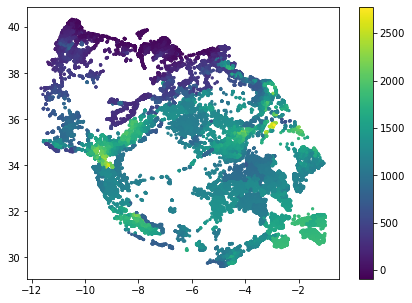

In [13]:
plot_map(df, df['gps_height'])

Imputamos los valores perdidos de las variables booleanas con el valor de la moda y las convertimos a numéricas.

In [33]:
# Rellenamos con la moda
df.permit.fillna(df.permit.mode().values[0], inplace=True)
df.public_meeting.fillna(df.permit.mode().values[0], inplace=True)

# Convertimos a numéricos
df.loc[:, ['permit', 'public_meeting']] = df.loc[:, ['permit', 'public_meeting']].astype('int')

Para las variables categóricas nominales se ha decidido rellenar los valores perdidos a 'unknown'. Además es han convertido todos los valores a minúsculas.

In [35]:
# Rellenamos valores nulos categóricos con 'unknown' y convertimos a lower todos los valores
df.select_dtypes(include = 'O').fillna('unknown', inplace=True)
for col in df.select_dtypes(include = 'O'):
    df.loc[:, col] = df[col].str.lower()

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Posteriormente, realizamos el encoding de las variables categóricas para pasarlas a numéricas. No se cuenta con información adicional del negocio como para realizar una transformación manual de los valores, por lo que se han realizado experimentos con LabelEncoder, FrequencyEncoder y TargetEncoder. No se ha encontrado apenas diferencias entre ellos, por lo que nos mantenemos con LabelEncoder para la transformación de categóricas a numéricas.

In [51]:
# Label Encoding #
df_encoded = df.copy()
for col in df.select_dtypes(include='O').drop(columns=[]):
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])
    
# Freq Encoding #
#for col in df.select_dtypes(include='O').drop(columns=[]):
#    df_encoded.loc[:,col] = df_encoded[col].map(df_encoded.groupby(col).size()/len(df))*100

# Target Encoding #
#for col in ['ward']:
#    te = ce.TargetEncoder().fit(df_encoded[:len(tag)][col], tag)
#    df_encoded[col] = te.transform(df_encoded[col])

# Dummy Encoding #
df_encoded = pd.get_dummies(df_encoded,drop_first=True)

Entrenamos un ensemble de modelos de clasificación para conocer la importancia de las variables de nuestros datos.

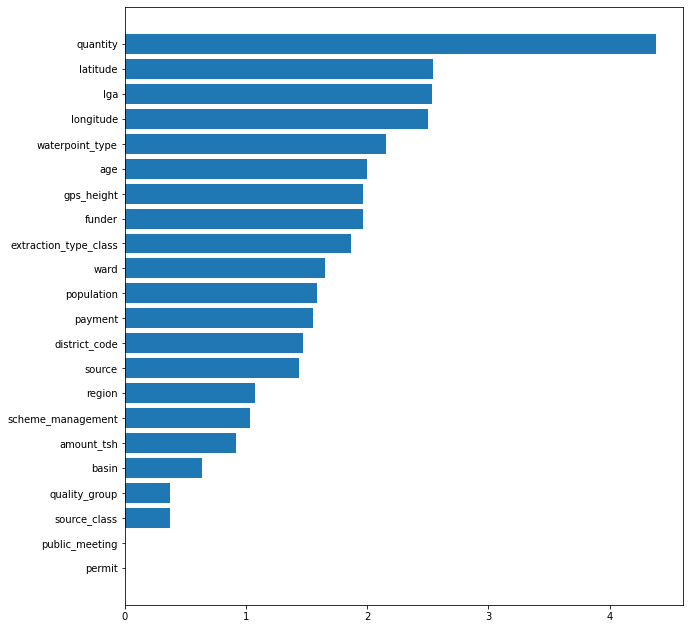

In [52]:
# Imprimimos la importancia de las variables para 3 modelos diferentes (Random Fores, XGBoost, CatBoost), 
# se calcula en base a la media de los 3 modelos. 
importances = find_features_importance(df_encoded[:len(tag)], tag)

Observamos que la variable `quantity` es la más relevante con diferencia. Realizamos un dibujo de barras para observar cómo se relaciona con la variable objetivo.

Cabe destacar que los valores de 'enough' y 'dry' son los más decisivos en cuanto a su relación con la variable objetivo (este diagrama se puede realizar para todas las variables (se recomienda que no tenga un alto número de valores únicos), para poder unificar aquellas que sean similares o con poca cantidad de datos, con el objetivo de simplificar los modelos y el entendimiento de estos).

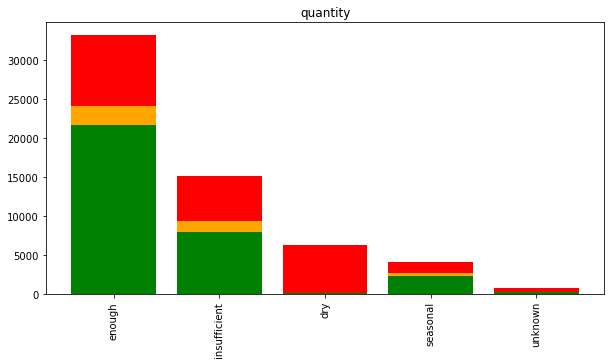

In [37]:
plot_categoricals(df[:len(tag)], tag, 'quantity')

In [53]:
# Eliminamos las variables que apenas aportan información
low_importance = [
    'public_meeting',
    'permit',
]

df_encoded.drop(columns=low_importance, inplace=True)

Una vez que contamos con nuestros datos procesados, procedemos a separar los datos en 3 conjuntos:
- Entrenamiento (80%  de los datos de train)
- Validación (20% de los datos de train)
- Testing (El conjunto de datos a predecir)

In [54]:
# Separamos en train y test, y a su vez los datos de train en train y validacion (80-20)
train = df_encoded[:len(tag)]
test = df_encoded[len(tag):]

X_train, X_val, y_train, y_val = train_test_split(train, tag, test_size=0.2, random_state=42)

# Train

En la fase de entrenamiento se han realizado múltiples pruebas, pero enseñamos los modelos que mejores resultados han ofrecido (otros modelos probados obtenían resultados de 0.5-0.6 en accuracy, por lo que los descartamos).

El primer paso es realizar un KFold para la evaluación de los modelos, de esta forma aseguramos que el entrenamiento de los modelos no depende del azar.

In [11]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

A continuación entrenamos 4 modelos diferentes de clasificación: Random Fores, XGBoost, CatBoost y Bagging. Todos ellos pasarán por un GridSearch o RandomSearch para la optimización de hiperparámetros.

In [18]:
# RandomForest
param_grid = { 'n_estimators': range(100,1100,100),
             'max_depth' : range(1,50,5),      
             'min_samples_split':[1, 5, 10, 20, 30]}

param_grid = { 'n_estimators': range(900,1100,10),
             'max_depth' : range(30,40,1),      
             'min_samples_split':[3, 4, 5, 6, 7]}

rf = RandomForestClassifier(random_state=42, warm_start = True, n_jobs=-1)

grid_search_rf = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, cv = skf, n_iter = 100,
                               verbose = 2, scoring = 'accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

print('Best Score:', grid_search_rf.best_score_)

rf = grid_search_rf.best_estimator_.fit(X_train, y_train)
print(rf)
print(accuracy_score(y_train, rf.predict(X_train)))
print(accuracy_score(y_val, rf.predict(X_val)))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Score: 0.810563973063973
RandomForestClassifier(max_depth=31, min_samples_split=6, n_estimators=1030,
                       n_jobs=-1, random_state=42, warm_start=True)
0.9488005050505051
0.8127946127946128


In [ ]:
# XGBoost
param_grid = { 'n_estimators': range(100,1100,100),
             'max_depth' : range(10,20,1)}

param_grid = { 'n_estimators': range(100,1100,100),
             'max_depth' : range(10,15,1)}

xgb = XGBClassifier(random_state=42, n_jobs=-1, verbosity = 0, tree_method = "hist")

grid_search_xgb = RandomizedSearchCV(estimator = xgb, param_distributions = param_grid, cv = skf, n_iter = 50,
                               verbose = 2, scoring = 'accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train,  eval_metric = 'mlogloss',)
print('Best Score:', grid_search_xgb.best_score_)

xgb = grid_search_xgb.best_estimator_.fit(X_train, y_train)
print(xgb)
print(accuracy_score(y_train, xgb.predict(X_train)))
print(accuracy_score(y_val, xgb.predict(X_val)))

In [ ]:
# CatBoost
param_grid = { 'max_depth': [7,8,10],
              'iterations': [1000, 750, 500],
              'rsm' :[0.5, 0.3, 0.2]}

cat = CatBoostClassifier(random_state=42, silent=True, thread_count=-1)

grid_search_cat = RandomizedSearchCV(estimator = cat, param_distributions = param_grid, cv = skf, n_iter = 25, 
                               verbose = 2,  scoring = 'accuracy', n_jobs=-1)

grid_search_cat.fit(X_train, y_train)
print('Best Score:', grid_search_cat.best_score_)

cat = grid_search_cat.best_estimator_.fit(X_train, y_train)
print(cat)
print(accuracy_score(y_train, cat.predict(X_train)))
print(accuracy_score(y_val, cat.predict(X_val)))

In [ ]:
# Bagging
param_grid = { 'n_estimators': range(100,1100,100),
              'max_features': np.linspace(0,0.9,20)}

param_grid = { 'n_estimators': range(500,700,25),
              'max_features': np.linspace(0,0.9,20)}

bag = BaggingClassifier(random_state=42, n_jobs=-1)

grid_search_bag = RandomizedSearchCV(estimator = bag, param_distributions = param_grid, cv = skf, n_iter = 50,
                               verbose = 2, scoring = 'accuracy', n_jobs=-1)
grid_search_bag.fit(X_train, y_train )
 
print('Best Score:', grid_search_bag.best_score_)

bag = grid_search_bag.best_estimator_.fit(X_train, y_train)
print(bag)
print(accuracy_score(y_train, bag.predict(X_train)))
print(accuracy_score(y_val, bag.predict(X_val)))

# Voting

Finalmente, se ha utilizado la herramienta de VotingClassifier para realizar una votación de los resultados de cada modelo. Se ha usado la técnica 'soft', que hará una suma de las probabilidades de cada predicción y escogerá el valor con mayor probabilidad.

Se han entrenado 2 Voting Classifiers diferentes cambiando los pesos de la votación en base a los resultados de los modelos.

In [ ]:
vc1 = VotingClassifier([('RandomForest', grid_search_rf.best_estimator_), 
                        ('XGBoost', grid_search_xgb.best_estimator_),
                        ('CAT', grid_search_cat.best_estimator_), 
                        ('Bagging', grid_search_bag.best_estimator_)], voting = 'soft')                  
vc1.fit(X_train , y_train)

preds_train = vc1.predict(X_train)
print("Accuracy score train: {}".format(accuracy_score(y_train , preds_train)))
preds_val = vc1.predict(X_val)
print("Accuracy score test: {}".format(accuracy_score(y_val, preds_val)))

In [470]:
vc2 = VotingClassifier([('RandomForest', grid_search_rf.best_estimator_), 
                        ('XGBoost', grid_search_xgb.best_estimator_),
                        ('CAT', grid_search_cat.best_estimator_), 
                        ('Bagging', grid_search_bag.best_estimator_)], voting = 'soft', weights=[0.9, 1, 0.8, 0.75])                  
vc2.fit(X_train , y_train)

preds_train = vc2.predict(X_train)
print("Accuracy score train: {}".format(accuracy_score(y_train , preds_train)))
preds_val = vc2.predict(X_val)
print("Accuracy score test: {}".format(accuracy_score(y_val, preds_val)))

Accuracy score train: 0.9438552188552188
Accuracy score test: 0.8152356902356902


Se observa que no hay apenas diferencia entre estos, con lo que decidimos mantenernos con el Voting Classifier inicial (sin pesos).

In [ ]:
vc1.fit(train, tag)
vc2.fit(train, tag)

print(accuracy_score(tag, vc1.predict(train)))
print(accuracy_score(tag, vc2.predict(train)))

# Testing

Una vez tengamos el modelo o ensemble de modelos listo, realizamos las predicciones del conjunto de test, las convertimos al formato deseado para la competición y guardamos el archivo como csv.

In [127]:
preds_test = vc1.predict(test)

In [128]:
convert = map(lambda x: 'functional' if x == 0 else ('functional needs repair' if x == 1 else 'non functional'), preds_test)
result = pd.DataFrame({'id':test_ids,'status_group':convert})
result

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


In [129]:
result.to_csv('pump_it_up_predictions.csv', index=False)

# Auto ML

Como exploración adicional, se ha realizado un entrenamiento de modelos de manera automática a partir de los datos ya procesados, haciendo uso de la librería H2O

In [ ]:
import h2o
from h2o.automl import H2OAutoML

In [ ]:
# Transformamos los datos al formato requerido por la librería H2O
X_train['tag'] = y_train
X_train = h2o.H2OFrame(X_train)
X_train['tag'] = X_train['tag'].asfactor()

X_val['tag'] = y_val
X_val = h2o.H2OFrame(X_val)
X_val['tag'] = X_val['tag'].asfactor()

x_columns = X_train.columns
x_columns.remove('tag')

train['tag'] = tag
train = h2o.H2OFrame(train)
train['tag'] = train['tag'].asfactor()

test = h2o.H2OFrame(test)

In [11]:
h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.291-b10, mixed mode)
  Starting server from D:\ProgramData\Anaconda3\envs\python38\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Luis\AppData\Local\Temp\tmpchsym0w5
  JVM stdout: C:\Users\Luis\AppData\Local\Temp\tmpchsym0w5\h2o_Luis_started_from_python.out
  JVM stderr: C:\Users\Luis\AppData\Local\Temp\tmpchsym0w5\h2o_Luis_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,13 days
H2O_cluster_name:,H2O_from_python_Luis_1l3usa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.542 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Entrenamos 20 modelos autoseleccionados por la librería y observamos cuál es el que mejor resultados ha ofrecido.

In [ ]:
# Run AutoML for 20 base models
aml = H2OAutoML(max_models=25, seed=42)
aml.train(x=train.columns[:-1], y='tag', training_frame=train)

In [22]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,mean_per_class_error,logloss,rmse,mse
GBM_grid_1_AutoML_1_20220302_131751_model_3,0.325351,0.497052,0.38628,0.149212
StackedEnsemble_AllModels_4_AutoML_1_20220302_131751,0.334295,0.465873,0.386363,0.149276
StackedEnsemble_AllModels_6_AutoML_1_20220302_131751,0.335073,0.465938,0.386146,0.149109
StackedEnsemble_AllModels_3_AutoML_1_20220302_131751,0.335096,0.465861,0.386406,0.14931
StackedEnsemble_BestOfFamily_5_AutoML_1_20220302_131751,0.335383,0.470212,0.387936,0.150495
GBM_4_AutoML_1_20220302_131751,0.335979,0.477602,0.388093,0.150616
StackedEnsemble_BestOfFamily_4_AutoML_1_20220302_131751,0.336318,0.470314,0.387995,0.15054
DRF_1_AutoML_1_20220302_131751,0.337557,0.517467,0.39086,0.152771
GBM_1_AutoML_1_20220302_131751,0.338066,0.480477,0.390309,0.152341
StackedEnsemble_BestOfFamily_7_AutoML_1_20220302_131751,0.339002,0.470601,0.388296,0.150774


Reentrenamos el mejor modelo con todos los datos, generamos las predicciones del conjunto de test y aplicamos el formato requerido para la competición. 

In [23]:
preds = aml.leader.predict(train)
accuracy_score(tag, preds.as_data_frame()['predict'])

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


0.9661952861952862

In [24]:
preds_test = aml.leader.predict(test).as_data_frame()['predict']

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
convert = map(lambda x: 'functional' if x == 0 else ('functional needs repair' if x == 1 else 'non functional'), preds_test)
result = pd.DataFrame({'id':test_ids,'status_group':convert})

result.to_csv('pump_it_up_predictions.csv', index=False)

Cabe destacar que los resultados obtenidos mediante H2O han sido levemente inferiores a los resultados mostrados en el apartado anterior. Aún así, es una forma rápida y sencilla de entrenar modelos y puede ser útil para cuando no se disponga de mucho tiempo o recursos.